##  **基于ItemsCF的商品推荐**
基于物品的协同过滤算法(itemCF)的思想是给用户推荐 和用户喜欢的商品相似的商品，并不是利用物品本身的内容属性来计算相似度（这是基于内容的推荐），而是通过分析用户行为记录（评分、购买、点击、浏览等行为）来计算两个物品的相似度，同时喜欢物品A和物品B的用户数越多，就认为物品A和物品B越相似。

本次分析数据有8个字段，具体说明如下：

| 字段              | 字段说明            | 提取说明                             | 
|-----------------|-----------------|----------------------------------|
|  InvoiceNO        |  发票编码           |  同一发票编码对应多种商品购买                      |
|  StockCode        |  商品标识           |  字段脱敏                           |
|  Description  |  对商品的描述     |    |
| Quantity   | 商品购买数量          | int                             |
| Invoice Date            | 购买时间            | 精确到小时级别                          |
| UnitPrice            | 商品单价            | float，俩位小数                          |
| CustomerID            | 客户用户id            |                           |
| Country            | 所在地区            |                           |
### 一. 数据导入预处理+特征工程
#### 1.1 数据导入

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from matplotlib.font_manager import FontProperties

# 设置中文字体为 SimHei，并解决负号显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

In [18]:
#导入Online Retail.xlsx 数据
df = pd.read_excel('Online Retail.xlsx', sheet_name='Online Retail', dtype=str, engine='calamine')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [19]:
# 查看商品种类数
df['StockCode'].nunique()


4070

#### 1.2 数据处理

In [20]:
# 查看df的列数据类型
df.dtypes

InvoiceNo      object
StockCode      object
Description    object
Quantity       object
InvoiceDate    object
UnitPrice      object
CustomerID     object
Country        object
dtype: object

In [21]:
# 数据类型转化
df.Quantity = df.Quantity.astype('int')
df.UnitPrice = df.UnitPrice.astype('float64')
df.InvoiceNo = df.InvoiceNo.astype('string')
df.StockCode = df.StockCode.astype('string')
df.Description = df.Description.astype('string')
df.CustomerID = df.CustomerID.astype('string')
df.Country = df.Country.astype('string')

In [22]:
# 删除空值
df.dropna(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  string 
 1   StockCode    406829 non-null  string 
 2   Description  406829 non-null  string 
 3   Quantity     406829 non-null  int32  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  string 
 7   Country      406829 non-null  string 
dtypes: float64(1), int32(1), object(1), string(5)
memory usage: 26.4+ MB


In [23]:
# 删除购买数量Quantity或单价UnitPrice小于等于0的行
df = df[(df['Quantity'].astype(float) > 0) & (df['UnitPrice'].astype(float) > 0)]

In [24]:
df[df['InvoiceNo'] == '536365' ]['StockCode'].count()

7

In [25]:
df[df['CustomerID'] == '17850' ]['StockCode'].count()

297

可见，存在用户的多次购买记录，每次购买记录又包含多种不同商品。故对数据处理时，以用户id为分类标准，对用户进行分组，对每个用户进行商品购买记录的统计。基于此进行商品推荐。
#### 1.3 数据构建

In [26]:
# 由于原数据集没有明确的评分，这里简单将购买数量作为评分
rating_df = df[['CustomerID', 'StockCode', 'Quantity']]
rating_df.columns = ['userID', 'itemID', 'rating']
rating_df.head()

,userID,itemID,rating
0,17850,85123A,6
1,17850,71053,6
2,17850,84406B,8
3,17850,84029G,6
4,17850,84029E,6


In [27]:
rating_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   userID  397884 non-null  string
 1   itemID  397884 non-null  string
 2   rating  397884 non-null  int32 
dtypes: int32(1), string(2)
memory usage: 10.6 MB


在基于物品的协同过滤 (Item CF) 推荐系统中，处理只购买了一种商品的订单 (即单一商品订单) ，这类订单确实不会对商品间的共现矩阵或相似度计算产生直接贡献，但保留这类订单可能加剧数据稀疏性，尤其是当数据集中存在大量单一商品订单时。稀疏数据会降低相似度计算的准确性。故选择删除此类订单。

In [28]:
# 查看只购买了一件物品的记录
rating_df.groupby('userID').filter(lambda x: len(x) == 1).head()

,userID,itemID,rating
252,13747,22180,8
3270,17925,21137,72
3534,15070,22086,36
4406,15823,BANK CHARGES,1
4988,14576,21111,12


In [29]:
del_list = rating_df.groupby('userID').filter(lambda x: len(x) == 1)['userID'].unique()
print(f"需要删除的用户数: {len(del_list)}")

# 删除只购买了一件物品的用户
rating_df = rating_df[~rating_df['userID'].isin(del_list)]

rating_df.info()

需要删除的用户数: 71
<class 'pandas.core.frame.DataFrame'>
Index: 397813 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   userID  397813 non-null  string
 1   itemID  397813 non-null  string
 2   rating  397813 non-null  int32 
dtypes: int32(1), string(2)
memory usage: 10.6 MB


In [30]:
# 合并同一用户购买的同类商品的rating得到最终用户购买数据集
ratings = rating_df.groupby(['userID', 'itemID']).sum().reset_index()
ratings.info()
ratings.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266721 entries, 0 to 266720
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   userID  266721 non-null  string
 1   itemID  266721 non-null  string
 2   rating  266721 non-null  int32 
dtypes: int32(1), string(2)
memory usage: 5.1 MB


,userID,itemID,rating
0,12347,16008,24
1,12347,17021,36
2,12347,20665,6
3,12347,20719,40
4,12347,20780,12
5,12347,20782,6
6,12347,20966,10
7,12347,21035,6
8,12347,21041,12
9,12347,21064,30


In [31]:
# 保存数据集
ratings.to_csv('ratings.csv', index=False)

### 二.基于物品的协同过滤算法（Items-based  Collaborative Filtering）
- N : 记录物品被多少用户购买过，如： N[“1”] = 10 表示有10个用户购买ID 为 “1”的商品；  N[“2”]∩N["3"] = 5表明同时购买了ID为“1”和“3”的商品的用户有5个 
- W : 相似矩阵，存储两个物品的相似度，如：W[“1”][“2”] = 0.66 表示ID 为 “1” 的商品和 ID 为 “2” 的商品相似度为 0.66 ；  
    相似度计算公式：W[“2”][“3”] =   N[“2”]∩N["3"] / sqrt(N[“2”] * N[“3”])
- train : 记录ratings中的数据， 格式为： train= { user : [[item1, rating1], [item2, rating2], …], …… }  
- k : 使用最相似的 k 个商品  
- n : 为用户推荐 n 个商品  

基于评分的加权余弦相似度对于物品 $i$ 和物品 $j$，它们的相似度计算公式为：  

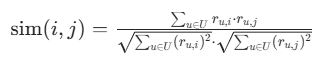

其中：  
- $U$ 是同时购买了物品 $i$ 和物品 $j$ 的用户集合；  
- $r_{u,i}$ 是用户 $u$ 对物品 $i$ 的评分（购买数量）。  

**公式说明**：  
- 分子为用户评分的点积，体现物品 $i$ 和 $j$ 在用户评分上的一致性；  
- 分母为评分向量的范数乘积，用于归一化相似度范围。  

**直观理解**：评分越高的用户对相似度贡献越大，反映了 "购买数量越多的用户对物品相似性的判断越可靠" 这一假设。

#### 2.1 加权余弦相似度计算与推荐

In [32]:
import random
import operator

class ItemBasedCF:
    def __init__(self):
        self.N = {}  # 记录每个物品被评分的平方和
        self.W = {}  # 物品相似度矩阵
        self.train = {}  # 训练数据，格式为{用户: [[物品1,评分1], [物品2,评分2], ...]}
        self.k = 30  # 选取与目标物品最相似的前k个物品
        self.n = 10  # 为用户推荐n个物品

    def get_data(self, file_path):
        print('开始从文件加载数据: ', file_path)
        with open(file_path, "r") as f:
            for i, line in enumerate(f, 0):
                if i != 0:  # 跳过首行标题
                    line = line.strip('\r\n')
                    user, item, rating = line.split(',')
                    self.train.setdefault(user, [])
                    self.train[user].append([item, float(rating)])  # rating转为float
        print('数据加载完成')

    def similarity(self):
        print('开始计算物品相似度矩阵...')
        
        # 第一步：计算分子（用户对两个物品评分的乘积之和）
        for user, item_ratings in self.train.items():
            items = [x[0] for x in item_ratings]  # 用户交互过的所有物品
            ratings = {x[0]: x[1] for x in item_ratings}  # 物品对应的评分
            
            for i in items:
                self.N.setdefault(i, 0)
                self.N[i] += ratings[i] ** 2  # 记录物品i被评分的平方和
                
                for j in items:
                    if i != j:
                        self.W.setdefault(i, {})
                        self.W[i].setdefault(j, 0)
                        # 累加用户对物品i和j的评分乘积
                        self.W[i][j] += ratings[i] * ratings[j]
        
        # 第二步：计算最终相似度（除以分母）
        for i, j_dict in self.W.items():
            for j, dot_product in j_dict.items():
                # 基于评分的加权余弦相似度公式
                denominator = (self.N[i] * self.N[j]) ** 0.5
                if denominator != 0:  # 避免除零错误
                    self.W[i][j] = dot_product / denominator
                else:
                    self.W[i][j] = 0
        
        print('物品相似度矩阵计算完成')

    def recommendation(self, user):
        print('开始为用户推荐物品，用户ID为: ', user)
        rank = {}  # 推荐物品及其得分
        watched_items = [x[0] for x in self.train.get(user, [])]  # 用户已购买的物品
        
        for i in watched_items:
            # 获取物品i的相似度列表，并按相似度排序
            similar_items = sorted(self.W.get(i, {}).items(), 
                                  key=operator.itemgetter(1), 
                                  reverse=True)[:self.k]
            
            for j, similarity in similar_items:
                if j not in watched_items:  # 排除用户已购买的物品
                    rank.setdefault(j, 0.)
                    # 用户对物品i的评分 * 物品i与物品j的相似度
                    user_rating = next((x[1] for x in self.train[user] if x[0] == i), 0)
                    rank[j] += user_rating * similarity
        
        # 返回得分最高的n个物品
        return sorted(rank.items(), key=operator.itemgetter(1), reverse=True)[:self.n]

if __name__ == "__main__":
    file_path = "D:\\学习\\python\\python数据分析\\course\\ratings.csv"
    itemBasedCF = ItemBasedCF()
    itemBasedCF.get_data(file_path)
    itemBasedCF.similarity()
    user = random.sample(list(itemBasedCF.train), 1)
    rec = itemBasedCF.recommendation('17022')
    print('\n为用户', '17022', '推荐的物品有:')
    print(rec)

开始从文件加载数据:  D:\学习\python\python数据分析\course\ratings.csv
数据加载完成
开始计算物品相似度矩阵...
物品相似度矩阵计算完成
开始为用户推荐物品，用户ID为:  17022

为用户 17022 推荐的物品有:
[('22744', 30.940993501525675), ('23302', 28.180009589220575), ('84032B', 27.946586286202262), ('72799E', 27.393982167161887), ('77101A', 27.182363454012652), ('22338', 26.96338326828365), ('23125', 26.80297966621712), ('85208', 26.71793518019064), ('23435', 26.21902166616846), ('21592', 26.151625527420265)]


#### 2.2 推荐结果

In [33]:
# 查看用户17022的购买记录
user_id = '17022'
display(f'用户{user_id}的购买记录为:',df[df['CustomerID'] == user_id])

# 查看用户17022的推荐结果
print(f'用户{user_id}的推荐结果为：',rec)

# 查看推荐结果中物品的描述，并按rec_list顺序排序
rec_list = [item[0] for item in rec]
rec_descriptions = df[df['StockCode'].isin(rec_list)][['StockCode', 'Description']].drop_duplicates()
rec_descriptions = rec_descriptions.set_index('StockCode').loc[rec_list].reset_index()
display(f'推荐结果中物品的描述为：', rec_descriptions)


'用户17022的购买记录为:'

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
450129,575166,85099B,JUMBO BAG RED RETROSPOT,10,2011-11-08 17:09:00,2.08,17022,United Kingdom
450130,575166,22578,WOODEN STAR CHRISTMAS SCANDINAVIAN,24,2011-11-08 17:09:00,0.29,17022,United Kingdom
450131,575166,22577,WOODEN HEART CHRISTMAS SCANDINAVIAN,24,2011-11-08 17:09:00,0.29,17022,United Kingdom
450132,575166,22579,WOODEN TREE CHRISTMAS SCANDINAVIAN,24,2011-11-08 17:09:00,0.29,17022,United Kingdom
450133,575166,23293,SET OF 12 FAIRY CAKE BAKING CASES,8,2011-11-08 17:09:00,0.83,17022,United Kingdom
450134,575166,23084,RABBIT NIGHT LIGHT,6,2011-11-08 17:09:00,2.08,17022,United Kingdom
450135,575166,22197,POPCORN HOLDER,12,2011-11-08 17:09:00,0.85,17022,United Kingdom


用户17022的推荐结果为： [('22744', 30.940993501525675), ('23302', 28.180009589220575), ('84032B', 27.946586286202262), ('72799E', 27.393982167161887), ('77101A', 27.182363454012652), ('22338', 26.96338326828365), ('23125', 26.80297966621712), ('85208', 26.71793518019064), ('23435', 26.21902166616846), ('21592', 26.151625527420265)]


'推荐结果中物品的描述为：'

,StockCode,Description
0,22744,MAKE YOUR OWN MONSOON CARD KIT
1,23302,KNEELING MAT HOUSEWORK DESIGN
2,84032B,CHARLIE + LOLA RED HOT WATER BOTTLE
3,72799E,IVORY PILLAR CANDLE SILVER FLOCK
4,77101A,UNION FLAG WINDSOCK
5,22338,STAR DECORATION PAINTED ZINC
6,23125,6PC WOOD PLATE SET DISPOSABLE
7,85208,SET/12 FUNKY FELT FLOWER PEG IN BAG
8,23435,3 RAFFIA RIBBONS VINTAGE CHRISTMAS
9,21592,RETROSPOT CIGAR BOX MATCHES


- **购买描述**：  
用户17022的购买商品描述分别为（大袋红色复古点、斯堪的纳维亚风格的木星圣诞装饰、木制心形圣诞、木制圣诞树、12 个童话蛋糕烘焙盒套装、兔子夜灯、爆米花架），所购物品基本都是围绕节日购买，基于其购买时间2011-11-08 17:09:00推测其可能正在筹备圣诞节装扮等。
- **推荐描述**:  
 推荐列表描述（rec_descriptions）为：   
*0* 22744 制作自己的季风卡套件  
*1*   23302 跪垫 家务设计  
*2*   84032B CHARLIE LOLA 红色热水瓶  
*3*   72799E 象牙柱蜡烛 银色植绒  
*4*   77101A Union Flag 风袋  
*5*   22338 星形装饰 涂漆锌  
*6*   23125 6 件套 一次性木板  
*7*   85208 SET/12 时髦毛毡花钉袋装  
*8*   23435 3 拉菲草丝带复古圣诞节  
*9*   21592 RETROSPOT 雪茄盒火柴  
#### 2.3 **分析**  
 基于物品协同过滤算法的准确性与合理性分析  


 **推荐结果与用户购买意图的匹配度**  
1. **节日主题的强相关性**  
   用户17022的购买历史集中在圣诞装饰（如木制心形圣诞、圣诞树）、节日烘焙（12个童话蛋糕烘焙盒套装）和氛围营造（兔子夜灯、爆米花架），明显指向圣诞节筹备。推荐列表中，**23435（拉菲草丝带复古圣诞节）、22338（星形装饰）、72799E（象牙柱蜡烛）** 等商品均为典型圣诞装饰品，与用户历史购买的主题高度一致。特别是“拉菲草丝带”和“星形装饰”，与用户已购的木制圣诞装饰在材质（木制/锌制）和用途（装饰场景）上具有相似性，体现了算法对“节日装饰”品类的准确捕捉。  

2. **关联需求的拓展性**  
   推荐中的**22744（季风卡套件）** 虽非直接圣诞商品，但可用于制作节日贺卡，与烘焙套装形成“节日手工+派对”的场景关联；**21592（雪茄盒火柴）** 则可能通过“氛围营造”这一隐性需求与蜡烛、夜灯产生关联。这种推荐不仅覆盖显性节日商品，还延伸到用户可能未明确购买但符合场景的关联品类，体现了算法对用户潜在需求的挖掘能力。  


**算法逻辑的合理性验证**  
1. **物品相似度计算的有效性**  
   基于物品的协同过滤通过分析商品共购模式计算相似度。例如，用户购买的“木制心形圣诞”与推荐的“星形装饰”可能在历史数据中被大量用户同时购买，形成强关联；“烘焙盒套装”与“季风卡套件”可能因“节日手工”场景产生共现。算法通过量化这种共现频率（如加权余弦相似度），将高相似度商品纳入推荐，符合“买过A的用户也买B”的逻辑。  



### 三. 基于RNN模型的销量预测

In [34]:
#数据预处理（）
#计算每个发票的购买金额（单价UnitPrice*数量Quantity），并汇总
df['Amount'] = df['UnitPrice'] * df['Quantity']
df_Invoice = df.groupby('InvoiceNo').agg({'Amount': 'sum', 'InvoiceDate': 'first'}).reset_index()
df_Invoice['InvoiceDate'] = pd.to_datetime(df_Invoice['InvoiceDate'])
# 以每天为时间区间。聚合汇总每天的销售总额
df_Invoice.set_index('InvoiceDate', inplace=True)
df_Invoice = df_Invoice.resample('D').sum().reset_index()
df_Invoice.drop('InvoiceNo', axis=1, inplace=True)

df_Invoice.rename(columns = {'InvoiceDate':'timestamp','Amount':'total_amount'},inplace=True)



df_Invoice

,timestamp,total_amount
0,2010-12-01,46376.49
1,2010-12-02,47316.53
2,2010-12-03,23921.71
3,2010-12-04,0.00
4,2010-12-05,31771.60
...,...,...
369,2011-12-05,58202.21
370,2011-12-06,46144.04
371,2011-12-07,69354.21
372,2011-12-08,50519.41


Epoch [10/50], Loss: 0.0067
Epoch [20/50], Loss: 0.0054
Epoch [30/50], Loss: 0.0042
Epoch [40/50], Loss: 0.0045
Epoch [50/50], Loss: 0.0040


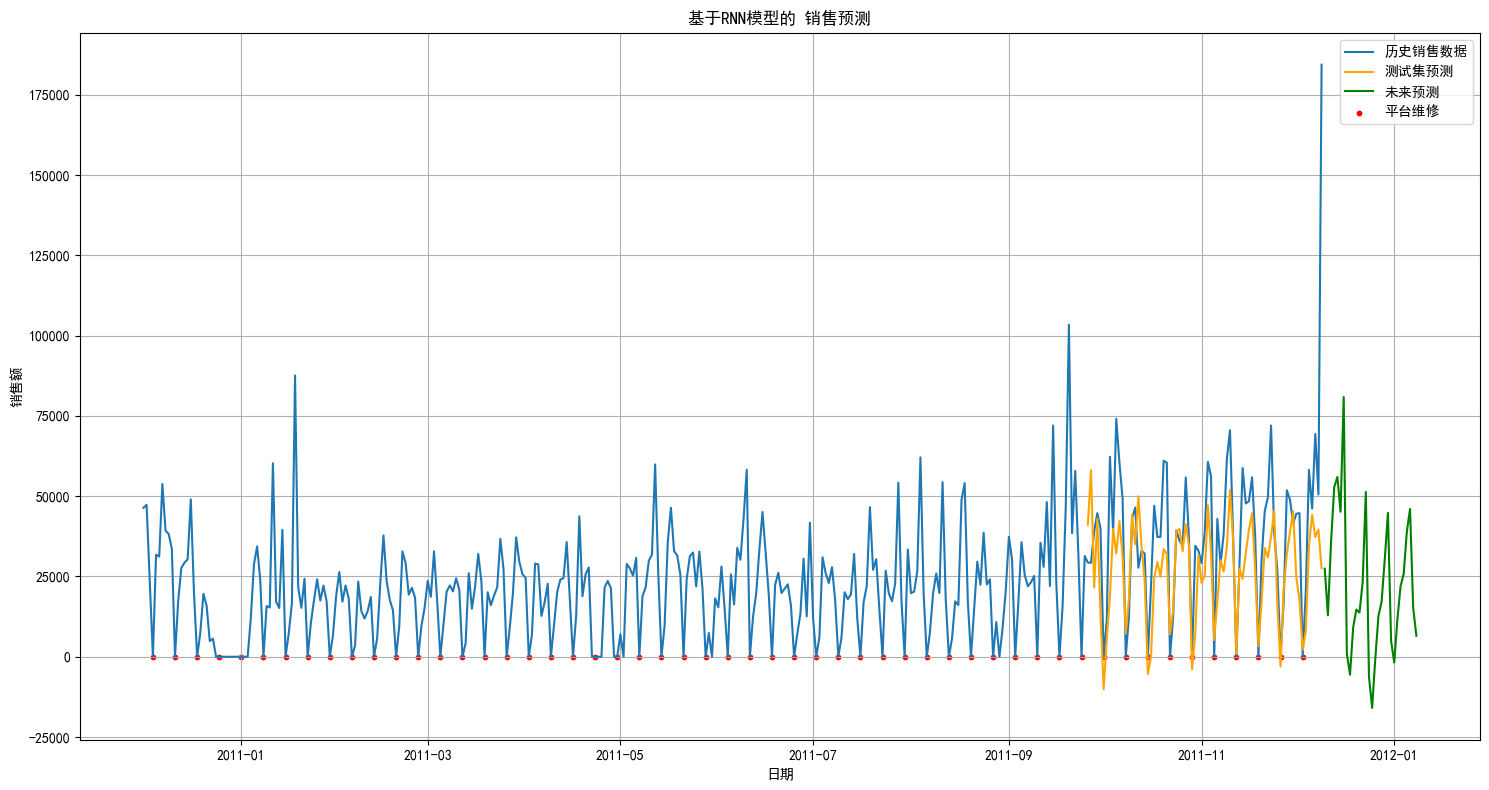

测试集MSE: 610591067.0438


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime

# 设置随机种子以保证结果可复现
torch.manual_seed(42)
np.random.seed(42)

# 自定义数据集类
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length]
        return x, y

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 训练模型
def train_model(model, train_loader, criterion, optimizer, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    return model

def predict_future(model, data, seq_length, future_periods, device):
    model.eval()
    predictions = []
    current_sequence = data[-seq_length:].clone().detach().to(device)
    
    with torch.no_grad():
        for _ in range(future_periods):
            pred = model(current_sequence.unsqueeze(0))  # 输出形状: [1, 1]
            predictions.append(pred.item())
            # 更新序列，添加预测值并移除最旧的值
            pred = pred.view(1, 1)  # 确保pred形状为 [1, 1]
            current_sequence = torch.cat((current_sequence[1:], pred))  # 拼接两个二维张量
    
    return np.array(predictions)

# 主函数
def main():
    # 使用您的数据集 df_Invoice
    global df_Invoice  # 从全局环境获取数据集
    
    # 确保数据按时间排序
    df_Invoice = df_Invoice.sort_values('timestamp')
    
    # 提取销售数据
    sales_data = df_Invoice['total_amount'].values
    
    # 数据预处理
    scaler = MinMaxScaler(feature_range=(0, 1))
    sales_data = scaler.fit_transform(sales_data.reshape(-1, 1)).flatten()
    
    # 划分训练集和测试集
    train_size = int(len(sales_data) * 0.8)
    train_data = sales_data[:train_size]
    test_data = sales_data[train_size:]
    
    # 准备数据
    seq_length = 14  # 使用前14天的数据预测下一天
    train_dataset = TimeSeriesDataset(torch.FloatTensor(train_data).view(-1, 1), seq_length)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 初始化模型
    input_size = 1
    hidden_size = 64
    num_layers = 2
    output_size = 1
    
    # 选择RNN模型
    model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    
    # 训练模型
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    model = train_model(model, train_loader, criterion, optimizer, device, epochs)
    
    # 预测测试集
    test_inputs = train_data[-seq_length:].tolist()
    test_predictions = []
    
    model.eval()
    with torch.no_grad():
        for i in range(len(test_data)):
            seq = torch.FloatTensor(test_inputs[-seq_length:]).view(1, seq_length, 1).to(device)
            pred = model(seq)
            test_predictions.append(pred.item())
            test_inputs.append(test_data[i])
    
    # 预测未来一个月
    future_periods = 30
    future_predictions = predict_future(model, torch.FloatTensor(sales_data).view(-1, 1), 
                                       seq_length, future_periods, device)
    
    # 反标准化
    test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    actual_sales = scaler.inverse_transform(np.array(sales_data).reshape(-1, 1))
    
    # 可视化
    plt.figure(figsize=(15, 8))
  
    plt.plot(df_Invoice['timestamp'], actual_sales, label='历史销售数据')
    
    test_dates = df_Invoice['timestamp'].iloc[train_size:train_size+len(test_predictions)]
    plt.plot(test_dates, test_predictions, label='测试集预测', color='orange')
    
    last_date = df_Invoice['timestamp'].iloc[-1]
    future_dates = [last_date + datetime.timedelta(days=i+1) for i in range(future_periods)]
    plt.plot(future_dates, future_predictions, label='未来预测', color='green')
    
    # 标记周六（销售为0的日期）
    saturdays = df_Invoice[df_Invoice['timestamp'].dt.weekday == 5]['timestamp']
    saturdays_sales = np.zeros(len(saturdays))
    plt.scatter(saturdays, saturdays_sales, color='red', s=10, label='平台维修')
    
    plt.title('基于RNN模型的 销售预测')
    plt.xlabel('日期')
    plt.ylabel('销售额')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 计算测试集MSE
    test_actual = scaler.inverse_transform(test_data.reshape(-1, 1))
    mse = mean_squared_error(test_actual, test_predictions)
    print(f'测试集MSE: {mse:.4f}')

if __name__ == "__main__":
    main()    